In [1]:
import PIL
import torch

from utils import (
    locate_points, get_segmentation_map,
    extract_binary_mask, get_effective_tokens
)
from pipeline import StableDiffusionInstructPix2PixPipeline

[nltk_data] Downloading package punkt to /home/jarvis/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jarvis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/jarvis/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
/home/jarvis/miniconda3/envs/lime/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Inputs and Model Load

Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00,  9.32it/s]


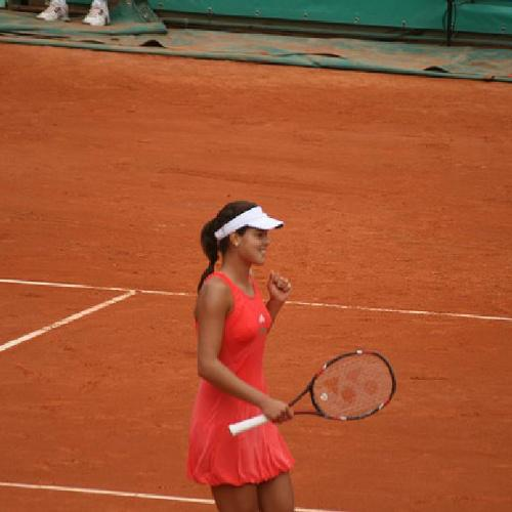

In [2]:
img_path = "./image.jpg"

input_image = PIL.Image.open(img_path).convert("RGB").resize((512, 512))

seed = 42
out_res = 128
prompt = "make her outfit black"

pipe = StableDiffusionInstructPix2PixPipeline.from_pretrained(
    "timbrooks/instruct-pix2pix", torch_dtype=torch.float32
)
pipe = pipe.to("cuda")

input_image

## Identify Region of Interest

100%|██████████| 30/30 [00:05<00:00,  5.52it/s]


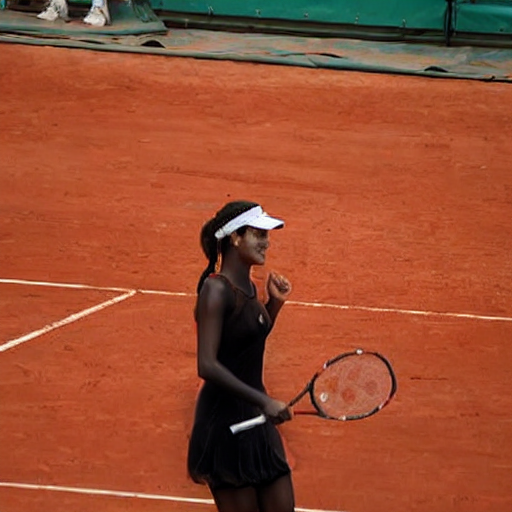

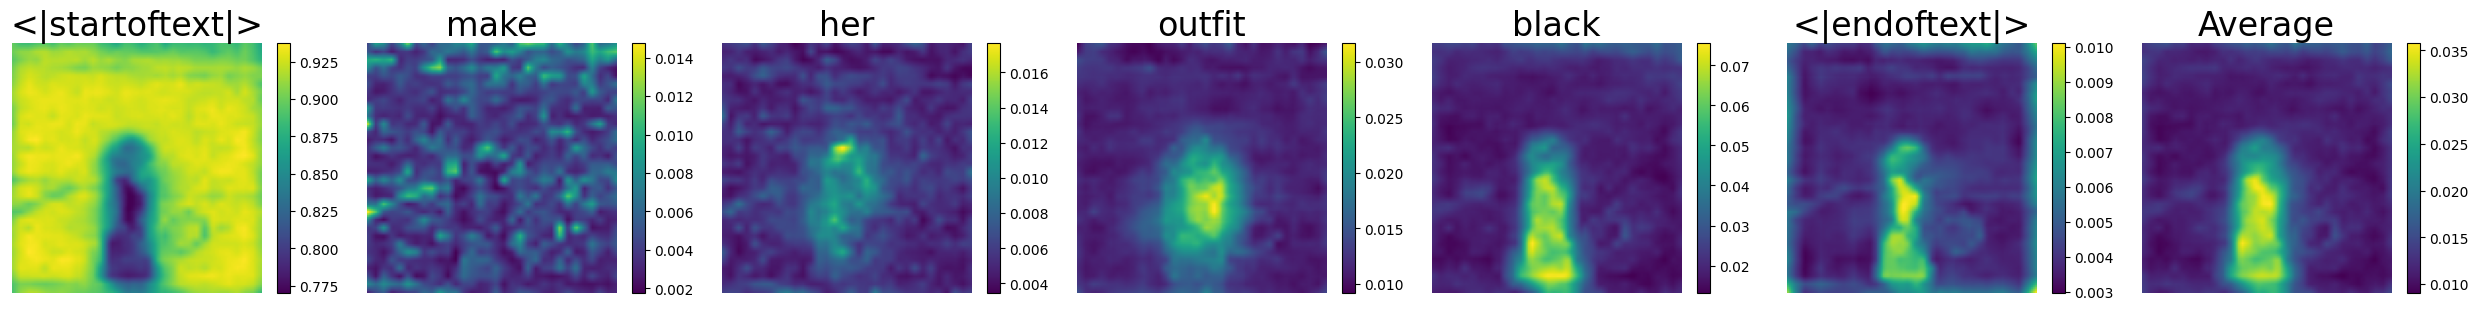

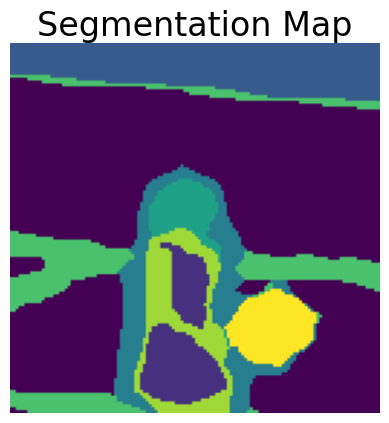

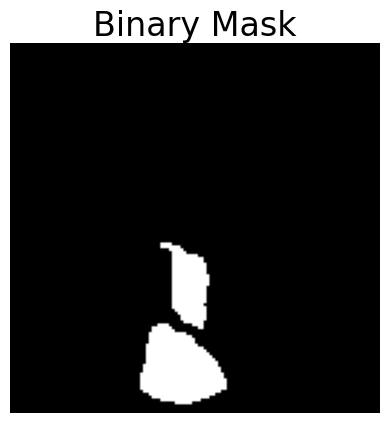

In [3]:
edited_image = pipe(
    prompt=prompt, 
    image=input_image,
    guidance_scale=5.5,
    image_guidance_scale=1.5,
    num_inference_steps=30, 
    attn_res=16, out_res=out_res, apply_mask_range=[0, 10],
    generator=torch.Generator(device="cpu").manual_seed(seed) if seed is not None else None
).images[0]

avg_attn, coordinates = locate_points(prompt, pipe.attention_store, pipe.tokenizer, top_k=1)
labels_spatial = get_segmentation_map(pipe.attention_store, out_res, num_clusters=8)
mask = extract_binary_mask(labels_spatial, coordinates)

edited_image

## Edit based on Region of Interest

100%|██████████| 30/30 [00:05<00:00,  5.47it/s]


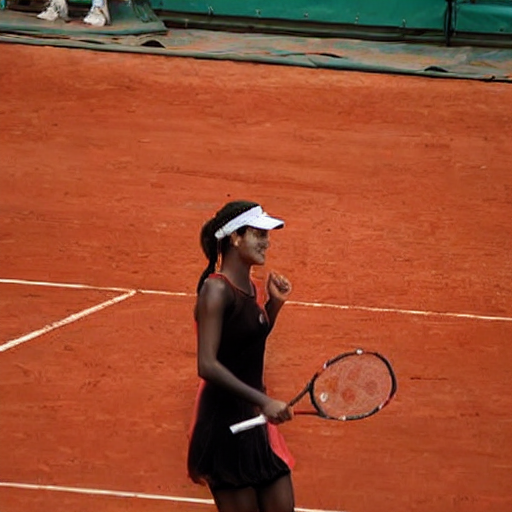

In [6]:
effective_tokens = get_effective_tokens(prompt, pipe.tokenizer)

edited_image = pipe(
    prompt=prompt, 
    image=input_image,
    guidance_scale=2,
    image_guidance_scale=1.5,
    num_inference_steps=30, 
    mask=mask, effective_tokens=effective_tokens, apply_mask_range=[0, 26],
    generator=torch.Generator(device="cpu").manual_seed(seed) if seed is not None else None,
).images[0]

edited_image

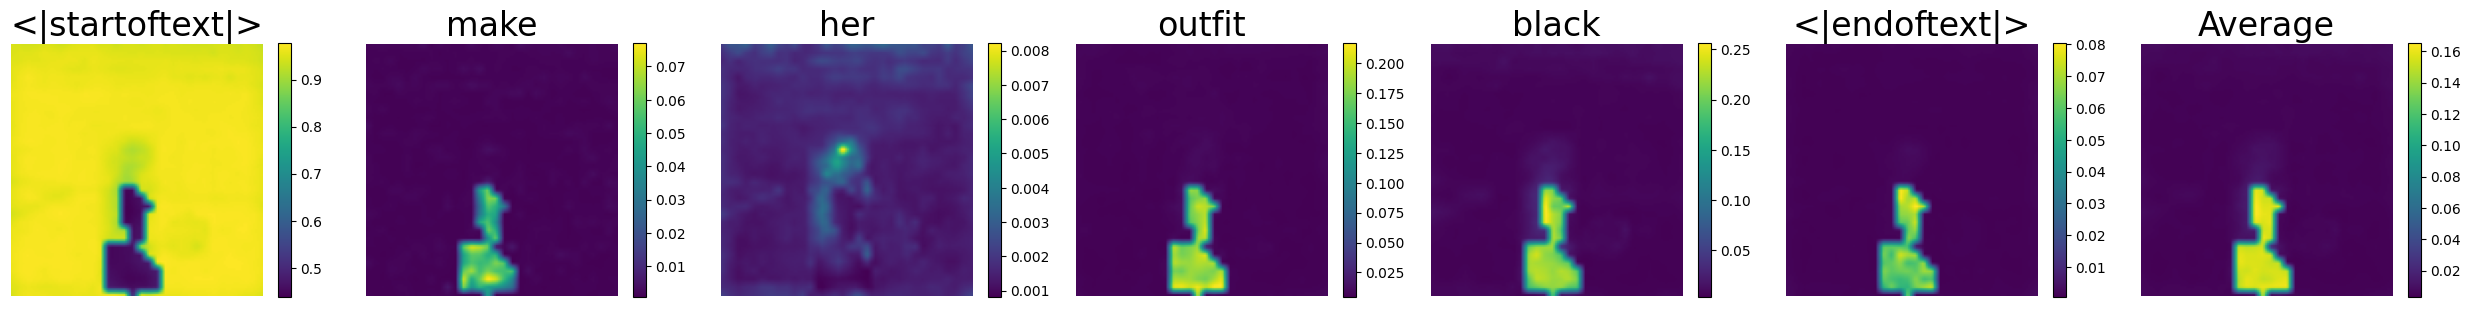

In [5]:
_ = locate_points(prompt, pipe.attention_store, pipe.tokenizer)